In [1]:
import regex as re
import os

from collections import defaultdict

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

DATA_DIR = '../ustawy'

In [2]:
with open('merged_bills.txt', 'w', encoding='UTF-8') as write_file:
    for file_name in os.listdir(DATA_DIR)[:200]:
        if re.match(r'.*\.txt$', file_name):
            with open(f'{DATA_DIR}/{file_name}', 'r', encoding='UTF-8') as file:
                write_file.write(file.read())
                write_file.write('\n')

# Load data

Year is retrieved from "USTAWA z dnia...". Note that:
- USTAWA can be written as U S T A W A,
- it can can be followed by a word like "konstytucyjna" or a phrase like "budżetowa na rok ...".

In [3]:
dataset = defaultdict(list)

for file_name in os.listdir(DATA_DIR):
    if re.match(r'.*\.txt$', file_name):
        with open(f'{DATA_DIR}/{file_name}', 'r', encoding='UTF-8') as file:
            bill = file.read()
            year_regex = r'u\s*s\s*t\s*a\s*w\s*a\s+' + r'\w*\s*\w*\s*\w*\s*\d*\s*' + r'z\s+dnia\s+\d+\s+\w+\s+' + r'(\d{4})'
            year_match = re.search(year_regex, bill, re.IGNORECASE)
            if year_match is None:
                print(f'Cannot read {file_name}')
            else:
                year = int(year_match.group(1))
                dataset[year].append(bill)
            
dataset_years = sorted(dataset.keys())
pd.DataFrame([(year, len(dataset[year])) for year in dataset_years], columns=['year', 'bill count'])

Cannot read 1996_400.txt


,year,bill count
0,1993,10
1,1994,41
2,1995,62
3,1996,56
4,1997,100
5,1998,80
6,1999,109
7,2000,161
8,2001,198
9,2002,7


# Utils

In [4]:
def count_everywhere(p):
    matches = 0
    for year in dataset_years:
         for bill in dataset[year]:
            matches += len(p.findall(bill))
    
    return matches

def count_by_year(p):
    matches = defaultdict(int)
    for year in dataset_years:
        for bill in dataset[year]:
            matches[year] += len(p.findall(bill))
            
    return matches

# Task 1

Based on https://lexlege.pl/zasady-techniki-prawodawczej/.

At first let's prepare a regex for a unit. It includes unit groups (e.g. "ust. 2-5", "ust. 2 i 4", "pkt 1, 2 i 6").

General comment: to allow for line breaks and "unusual spaces", I use '\s+' instead of ' ' most often.

In [5]:
# unit_regex = r'(art\.|ust\.|pkt|lit\.|§|tiret)\s*\w+(\s*i\s*\w+|\s*-\s*\w+)?'
unit_regex = r'(art\.|ust\.|pkt|lit\.|§|tiret)\s*\w+(\s*[,i-]\s*\w+)*'
print(unit_regex)

(art\.|ust\.|pkt|lit\.|§|tiret)\s*\w+(\s*[,i-]\s*\w+)*


## 1.1. Addition

Now we can create the addition regex. It seems that "dodaje się" is the only phrase to add a unit.

In [6]:
addition_pattern = re.compile(r'dodaje\s+się\s+' + unit_regex, re.IGNORECASE)
print(addition_pattern.pattern)

dodaje\s+się\s+(art\.|ust\.|pkt|lit\.|§|tiret)\s*\w+(\s*[,i-]\s*\w+)*


In [7]:
addition_dict = count_by_year(addition_pattern)
# addition_dict

## 1.2. Removal

- Removal can be expressed as "skreśla się", but also as "uchyla się" (§ 85 technika prawodawcza). 
- What's important, if a unit is removed, it is always after the phrase (e.g. "w ... uchyla się ust. 5"). 
- There are other phrases that can be removed like "wyrazy ..." or "rozdział ...", but they are not considered here.
- Rarely, there can be an expression like "skreśla się w ust. 1 pkt 5"; it is included in the regex.

In [8]:
removal_pattern = re.compile(r'(skreśla|uchyla)\s+się\s+(w\s+' + unit_regex + r'\s+)?' + unit_regex, re.IGNORECASE)

print(removal_pattern.pattern)

(skreśla|uchyla)\s+się\s+(w\s+(art\.|ust\.|pkt|lit\.|§|tiret)\s*\w+(\s*[,i-]\s*\w+)*\s+)?(art\.|ust\.|pkt|lit\.|§|tiret)\s*\w+(\s*[,i-]\s*\w+)*


In [9]:
removal_dict = count_by_year(removal_pattern)
# removal_dict

## 1.3 Change

Only "otrzymuje brzmienie" expression. Assumption: change of a single ("otrzymuje brzmienie") or multiple ("otrzymują brzmienie") units.

In [10]:
change_pattern = re.compile(unit_regex + r'\s+otrzymuj(e|ą)\s+brzmienie', re.IGNORECASE)
print(change_pattern.pattern)

(art\.|ust\.|pkt|lit\.|§|tiret)\s*\w+(\s*[,i-]\s*\w+)*\s+otrzymuj(e|ą)\s+brzmienie


In [11]:
change_dict = count_by_year(change_pattern)
# change_dict

# Task 3

In [12]:
amendments_df = pd.DataFrame(zip(addition_dict.values(), removal_dict.values(), change_dict.values()), index=dataset_years, columns=['addition', 'removal', 'change'])
amendments_df

,addition,removal,change
1993,35,7,64
1994,86,31,83
1995,266,83,353
1996,280,148,490
1997,429,163,684
1998,493,223,955
1999,204,61,255
2000,931,326,1493
2001,1191,305,1562
2002,13,2,31


In [13]:
amendments_df_norm = amendments_df.div(amendments_df.sum(axis=1), axis=0) * 100
amendments_df_norm

,addition,removal,change
1993,33.018868,6.603774,60.377358
1994,43.000000,15.500000,41.500000
1995,37.891738,11.823362,50.284900
1996,30.501089,16.122004,53.376906
1997,33.620690,12.774295,53.605016
1998,29.503291,13.345302,57.151406
1999,39.230769,11.730769,49.038462
2000,33.854545,11.854545,54.290909
2001,38.947024,9.973839,51.079137
2002,28.260870,4.347826,67.391304


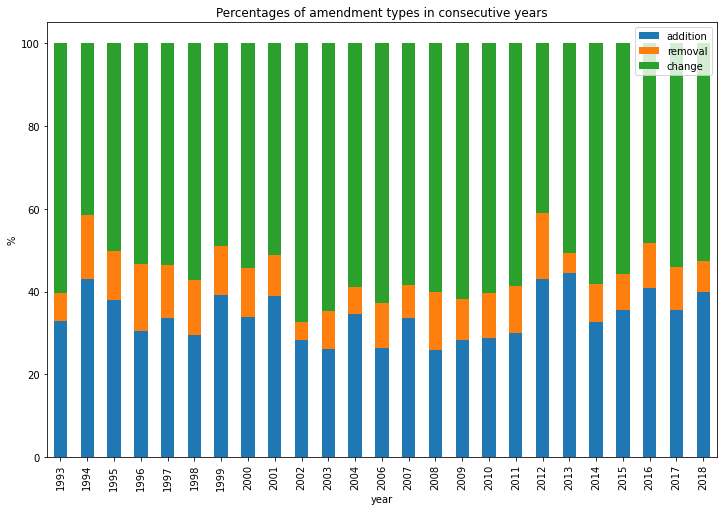

In [14]:
amendments_df_norm.plot(kind='bar', stacked=True, figsize=(12, 8), xlabel='year', ylabel='%', title='Percentages of amendment types in consecutive years')
None

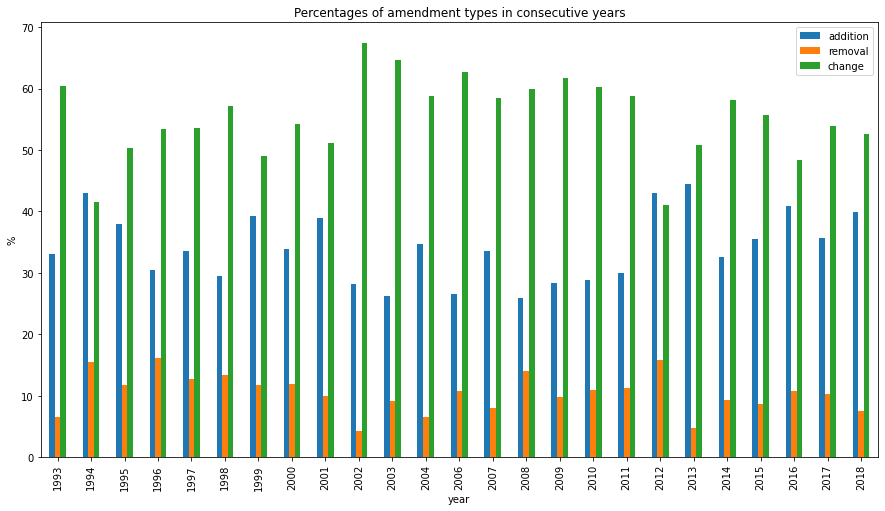

In [15]:
amendments_df_norm.plot(kind='bar', figsize=(15, 8), xlabel='year', ylabel='%', title='Percentages of amendment types in consecutive years')
None

# Task 4

Source of the inflectional forms: *Synteza morfologiczna* in http://morfeusz.sgjp.pl/demo/

In [16]:
bill_regex = r'\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\b'
bill_regex

'\\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\\b'

In [17]:
pattern_4 = re.compile(bill_regex, re.IGNORECASE)
print(pattern_4.pattern)

\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\b


In [18]:
count_4 = count_everywhere(pattern_4)
count_4

24934

# Task 5

In [19]:
pattern_5 = re.compile(bill_regex + r'\s+z\s+dnia', re.IGNORECASE)
print(pattern_5.pattern)

\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\b\s+z\s+dnia


In [20]:
count_5 = count_everywhere(pattern_5)
count_5

8588

# Task  6

In [21]:
pattern_6 = re.compile(bill_regex + r'(?!\s+z\s+dnia)', re.IGNORECASE)
print(pattern_6.pattern)

\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\b(?!\s+z\s+dnia)


In [22]:
count_6 = count_everywhere(pattern_6)
count_6

16346

In [23]:
print('4.                         ustawa:', count_4)
print('5.    ustawa followed by "z dnia":', count_5)
print('6. ustawa not follwed by "z dnia":', count_6)
print('                 sum of 5. and 6.:', count_5 + count_6)

4.                         ustawa: 24934
5.    ustawa followed by "z dnia": 8588
6. ustawa not follwed by "z dnia": 16346
                 sum of 5. and 6.: 24934


The result is correct.

# Task 7

In [24]:
pattern_7 = re.compile(bill_regex + r'(?!\s+o\s+zmianie)', re.IGNORECASE)
print(pattern_7.pattern)

\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\b(?!\s+o\s+zmianie)


In [25]:
count_7 = count_everywhere(pattern_7)
count_7

24900

In [26]:
count_4 - count_7

34

Almost all the occurences of "ustawa" are NOT followed by "o zmianie".

# Task 8

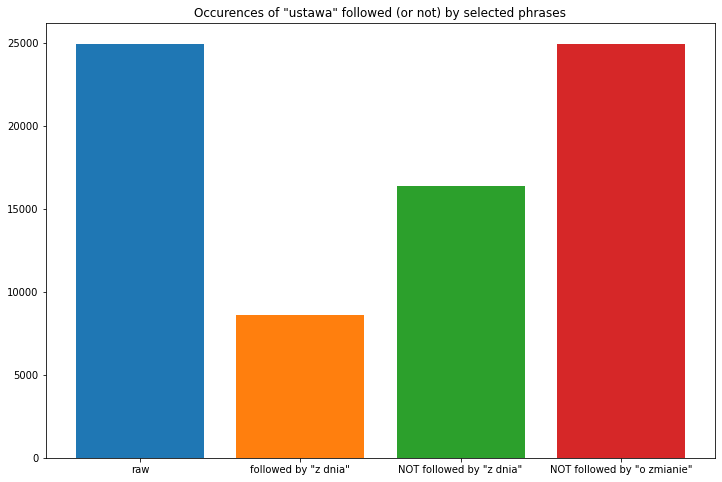

In [27]:
titles = ['ustawa', 'ustawa followed by "z dnia"', 'ustawa NOT followed by "z dnia"', 'ustawa NOT followed by "o zmianie"']
data = [count_4, count_5, count_6, count_7]

plt.figure(figsize=(12, 8))

plt.bar('raw', count_4)
plt.bar('followed by "z dnia"', count_5)
plt.bar('NOT followed by "z dnia"', count_6)
plt.bar('NOT followed by "o zmianie"', count_7)

plt.title('Occurences of "ustawa" followed (or not) by selected phrases')
plt.show()